In [28]:
 # Necessary libraries
import pandas as pd
import numpy as np
import csv 
import matplotlib.pyplot as plt

from pandas import read_csv
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import warnings
import seaborn as sns

In [29]:
# Reading in the dataset
df = pd.read_csv('03-Oct-2023_patAnalysis_2.csv')

# Performing interpolation on filtered PAT, still using pandas dataframe
data_squashed = df.dropna(subset=['wrist@(9mm,809nm)_filtered_pat_bottomTI'])
time = df['wrist@(9mm,809nm)_delay_s']

interp_func = interp1d(data_squashed['wrist@(9mm,809nm)_delay_s'].array, data_squashed['wrist@(9mm,809nm)_filtered_pat_bottomTI'].array, kind='linear', fill_value="extrapolate")
pat_filt_int = interp_func(time) #Numpy array
df['filtered_pat_interpolated'] = pat_filt_int.tolist()
df = df.dropna(subset=['blood pressure_systolic'])
df

,"wrist@(9mm,809nm)_date","wrist@(9mm,809nm)_delay_s","wrist@(9mm,809nm)_raw_pat","wrist@(9mm,809nm)_filtered_pat_bottomTI","wrist@(9mm,809nm)_mask",blood pressure_systolic,blood pressure_mean,blood pressure_diastolic,filtered_pat_interpolated
24,27/10/2022 10:49,22.626,NaN,NaN,0,62.1268,44.71990,41.3756,0.367579
25,27/10/2022 10:49,23.482,NaN,NaN,0,63.6676,45.70430,41.8892,0.373935
26,27/10/2022 10:49,24.377,0.539193,NaN,0,65.2786,46.73355,42.4262,0.380581
27,27/10/2022 10:49,25.307,NaN,NaN,0,66.9526,47.80305,42.9842,0.387487
28,27/10/2022 10:49,26.263,0.725741,NaN,0,68.6734,48.90245,43.5578,0.394585
...,...,...,...,...,...,...,...,...,...
2321,27/10/2022 11:52,3798.134,0.180315,0.185350,1,116.1598,80.15980,60.9665,0.185350
2322,27/10/2022 11:52,3799.034,0.181337,0.185817,1,115.8898,79.88980,60.7415,0.185817
2323,27/10/2022 11:52,3799.944,0.186739,0.186459,1,115.6168,79.61680,60.5140,0.186459
2324,27/10/2022 11:52,3800.842,0.190720,0.187216,1,115.3474,79.34740,60.2895,0.187216


In [30]:
#indexes = df.index[(df['wrist@(9mm,809nm)_delay_s']== "27/10/2022 10:49")].tolist()

#print(indexes)

# Convert 'wrist@(9mm,809nm)_delay_s' column to datetime object
df['wrist@(9mm,809nm)_date'] = pd.to_datetime(df['wrist@(9mm,809nm)_date'], format='%d/%m/%Y %H:%M')

# Define start and end dates for the desired range
rest1_start = "2022-10-27 10:49"
rest1_end = "2022-10-27 11:19"

static_start="2022-10-27 11:28"
static_end = "2022-10-27 11:31"

dynamic_start = "2022-10-27 11:35"
dynamic_end = "2022-10-27 11:38"

mental_start = "2022-10-27 11:42"
mental_end = "2022-10-27 11:45"
# Use boolean indexing to filter the DataFrame based on the date range
df_rest = df[(df['wrist@(9mm,809nm)_date'] >= rest1_start) & (df['wrist@(9mm,809nm)_date'] <= rest1_end)]

df_rest

,"wrist@(9mm,809nm)_date","wrist@(9mm,809nm)_delay_s","wrist@(9mm,809nm)_raw_pat","wrist@(9mm,809nm)_filtered_pat_bottomTI","wrist@(9mm,809nm)_mask",blood pressure_systolic,blood pressure_mean,blood pressure_diastolic,filtered_pat_interpolated
24,2022-10-27 10:49:00,22.626,NaN,NaN,0,62.12680,44.71990,41.37560,0.367579
25,2022-10-27 10:49:00,23.482,NaN,NaN,0,63.66760,45.70430,41.88920,0.373935
26,2022-10-27 10:49:00,24.377,0.539193,NaN,0,65.27860,46.73355,42.42620,0.380581
27,2022-10-27 10:49:00,25.307,NaN,NaN,0,66.95260,47.80305,42.98420,0.387487
28,2022-10-27 10:49:00,26.263,0.725741,NaN,0,68.67340,48.90245,43.55780,0.394585
...,...,...,...,...,...,...,...,...,...
337,2022-10-27 11:19:00,1870.779,0.273070,0.207819,1,108.04945,75.61050,59.04945,0.207819
338,2022-10-27 11:19:00,1871.751,0.303814,0.209223,1,107.61205,75.12450,58.61205,0.209223
339,2022-10-27 11:19:00,1872.727,0.868619,NaN,0,107.17285,74.63650,58.17285,0.213587
340,2022-10-27 11:19:00,1873.680,0.127817,NaN,0,106.74400,74.16000,57.74400,0.217847


In [31]:
# Splitting of the dataset
X, y = df['filtered_pat_interpolated'].to_numpy().reshape(-1, 1), df['blood pressure_systolic'].to_numpy().reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [32]:
# Linear regression without any cross validation

lm_mod = LinearRegression()
lm_mod.fit(X_train, y_train)
print(f"The linear regression score on the training set is : {lm_mod.score(X_train, y_train)} \nThe coefficients are : {lm_mod.coef_}")

y_pred = lm_mod.predict(X_test)
print(f"The linear regression score on the testing set is : {lm_mod.score(X_test, y_test)}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"The root mean square error is: {rmse}.")

The linear regression score on the training set is : 0.03570988356094551 
The coefficients are : [[-17.55199687]]
The linear regression score on the testing set is : 0.03616687414192887
The root mean square error is: 18.262744048010404.


In [33]:
# Linear regression with K-fold cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for train_index, test_index in kf.split(X):
    X_train2, X_test2 = X[train_index], X[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    lm_2 = LinearRegression()
    lm_2.fit(X_train2, y_train2)
    y_pred2 = lm_2.predict(X_test2)
    mse = mean_squared_error(y_test2, y_pred2)
    mse_scores.append(mse)

# Calculate average mean squared error
average_rmse = np.sqrt(sum(mse_scores) / len(mse_scores))
print("Average Root Mean Squared Error:", average_rmse)

Average Root Mean Squared Error: 18.392230393009886


In [34]:
# Polynomial regression

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)
X_train3, X_test3, y_train3, y_test3 = train_test_split(poly_features, y, test_size=0.3, random_state=42)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train3, y_train3)

poly_reg_y_pred = poly_reg_model.predict(X_test3)
poly_reg_rmse = np.sqrt(mean_squared_error(y_test3, poly_reg_y_pred))
poly_reg_rmse

17.461088498362084

In [37]:
# Polynomial regression with rolling time series cross validation

# Set the window size for the rolling time series cross-validation
window_size = 60
n_features = len(poly_features)

# Initialize an empty list to store MSE and RMSE values
mse_scores = np.zeros(n_features)
rmse_scores = np.zeros(n_features)
#accuracy = []

preds = np.zeros(n_features)
test = np.zeros(n_features)


# Perform rolling time series cross-validation
for i in range(n_features - window_size):
    # Split the data into training and testing sets using the rolling window
    X_train_rolling, X_test_rolling = poly_features[i:i+window_size], poly_features[i+window_size:i+window_size+1]
    y_train_rolling, y_test_rolling = y[i:i+window_size], y[i+window_size:i+window_size+1]
    
    # Initialize and train the polynomial regression model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_train_rolling, y_train_rolling)
    
    # Make predictions on the test set
    poly_reg_y_pred = poly_reg_model.predict(X_test_rolling)
    # Fold MSE 
    fold_mse = mean_squared_error(y_test_rolling, poly_reg_y_pred)
    # Calculate RMSE for this fold and append it to the list of RMSE scores
    fold_rmse = np.sqrt(fold_mse)
    #fold_score = r2_score(y_test_rolling, poly_reg_y_pred)
    
    mse_scores[i] = fold_mse
    rmse_scores[i] = fold_rmse
    preds[i] = poly_reg_y_pred
    test[i] = y_test_rolling
    #mse_scores.append(fold_mse)
    #rmse_scores.append(fold_rmse)
    
    

# Calculate the average RMSE across all folds
average_mse = np.mean(mse_scores)
average_rmse = np.mean(rmse_scores)


# Print the average RMSE
print("Average MSE:", average_mse)
print("Average RMSE:", average_rmse)


Average MSE: 32.728127068953945
Average RMSE: 2.771149459733643


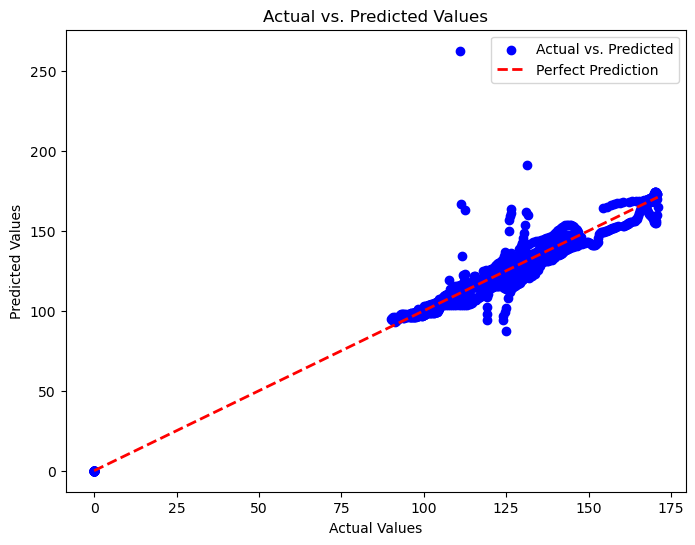

In [38]:

# Assuming poly_reg_y_pred contains the predicted values from your model
# and y_test3 contains the actual values from your test set

plt.figure(figsize=(8, 6))
plt.scatter(test, preds, color='blue', label='Actual vs. Predicted')
plt.plot([min(test), max(test)], [min(test), max(test)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

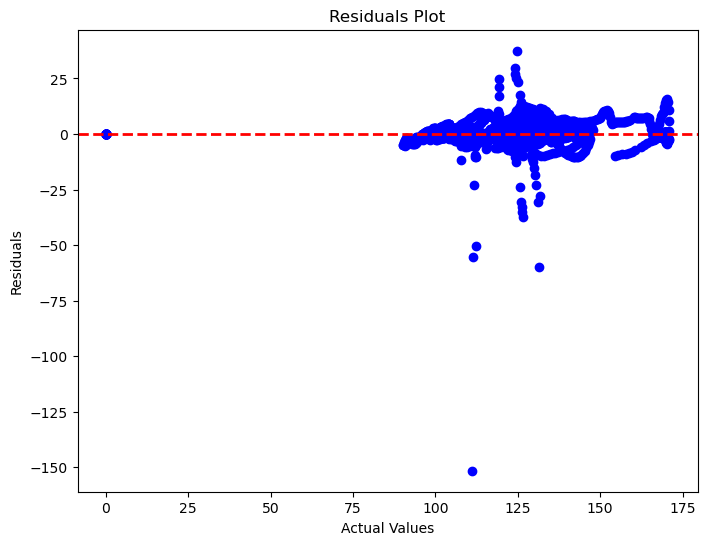

In [41]:
# Residuals plot

residuals = test - preds

plt.figure(figsize=(8, 6))
plt.scatter(test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

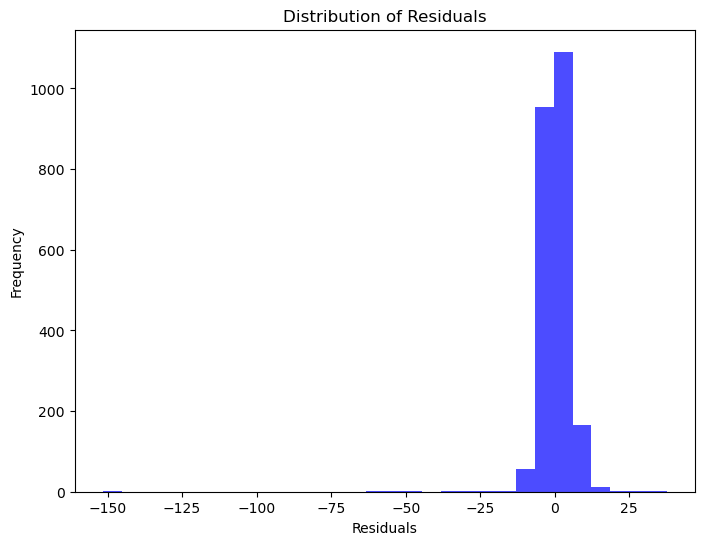

In [42]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()